In [1]:
import os
import pathlib
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import soundfile as sf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 35
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:

Path = "tolong.zip"


with zipfile.ZipFile(Path) as scream_zip:
  scream_zip.extractall("content")

In [43]:
Path = "speech.zip"

with zipfile.ZipFile(Path) as scream_zip:
  scream_zip.extractall("content")

In [3]:
scream_path = 'content'

commands = np.array(tf.io.gfile.listdir(str('content/')))
print('file : ', commands)

file :  ['tolong' '.ipynb_checkpoints' 'speach']


In [4]:
filenames = tf.io.gfile.glob(str(scream_path) +'/*/*.wav')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("files : ", num_samples)
# print('tensor : ', filenames)

files :  1181


In [5]:
import librosa
from pydub import AudioSegment
filenames = tf.io.gfile.glob(str(scream_path) + '/*/*.wav')
for i in filenames:
  sound = AudioSegment.from_wav(i)
  sound = sound.set_channels(1)
  sound.export(i, format="wav")

In [6]:
filenames = tf.random.shuffle(filenames)
train_files = filenames[:801]
val_files = filenames[801:991]
test_files = filenames[991:]

print(len(train_files))
print(len(val_files))
print(len(test_files))



801
190
190


In [7]:
test_file = tf.io.read_file(scream_path + '/tolong/tolong48.wav')
test_audio, _ = tf.audio.decode_wav(contents= test_file)
test_audio.shape

TensorShape([42231, 1])

In [8]:
ob = sf.SoundFile(scream_path + '/tolong/32.wav')
print('Sample rate: {}'.format(ob.samplerate))
print('Channels: {}'.format(ob.channels))
print('Subtype: {}'.format(ob.subtype))

Sample rate: 16000
Channels: 1
Subtype: PCM_16


In [9]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio)


In [10]:
def get_label(file_path):
  parts = tf.strings.split(
      input = file_path,
      sep = os.path.sep
  )
  return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

file_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = file_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls= AUTOTUNE
)

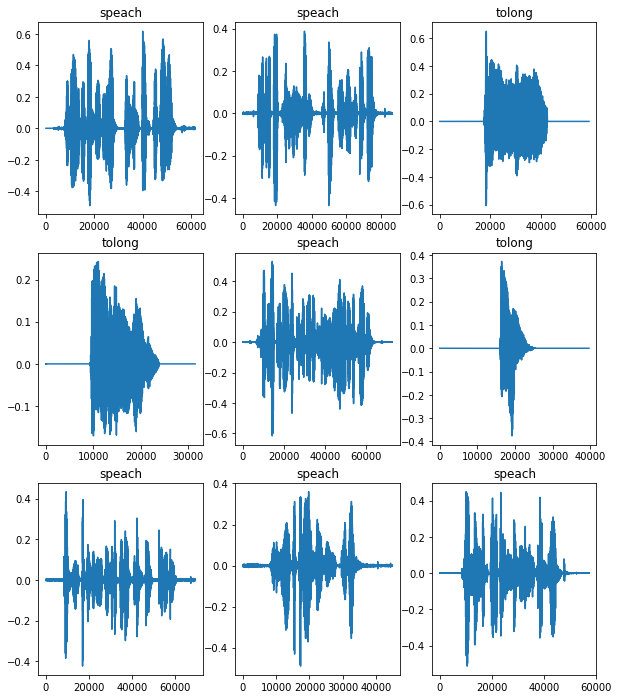

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  label = label.numpy().decode('utf-8')
  ax.set_title(label)


plt.show()

In [14]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype = tf.float32
  )

  waveform =  tf.cast(waveform, dtype = tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128
  )

  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [15]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label : ', label)
print('Waveform shape : ', waveform.shape)
print('Spectrogram shape', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=14000))

Label :  speach
Waveform shape :  (61760,)
Spectrogram shape (124, 129, 1)
Audio playback


In [75]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis= -1)
  
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num= width, dtype= int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

[    0   130   260   390   520   650   780   910  1040  1170  1300  1430
  1560  1690  1820  1950  2080  2210  2340  2470  2600  2731  2861  2991
  3121  3251  3381  3511  3641  3771  3901  4031  4161  4291  4421  4551
  4681  4811  4941  5071  5201  5332  5462  5592  5722  5852  5982  6112
  6242  6372  6502  6632  6762  6892  7022  7152  7282  7412  7542  7672
  7802  7932  8063  8193  8323  8453  8583  8713  8843  8973  9103  9233
  9363  9493  9623  9753  9883 10013 10143 10273 10403 10533 10664 10794
 10924 11054 11184 11314 11444 11574 11704 11834 11964 12094 12224 12354
 12484 12614 12744 12874 13004 13134 13264 13395 13525 13655 13785 13915
 14045 14175 14305 14435 14565 14695 14825 14955 15085 15215 15345 15475
 15605 15735 15865 15996]
range(0, 129)


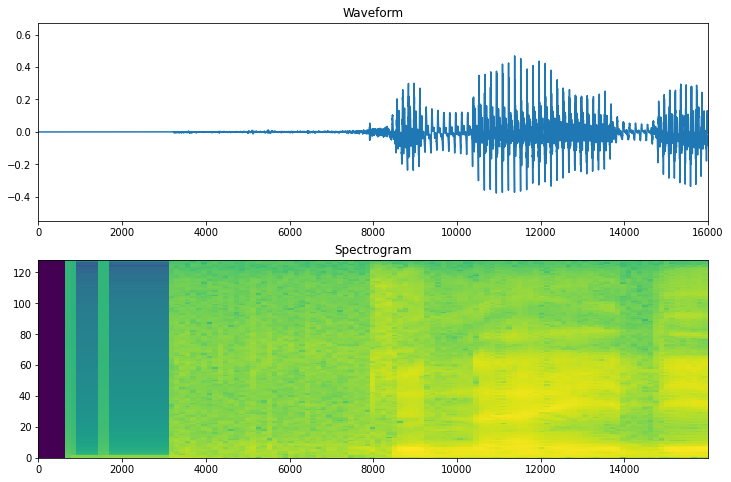

In [74]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [18]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
    map_func = get_spectrogram_and_label_id,
    num_parallel_calls= AUTOTUNE
)

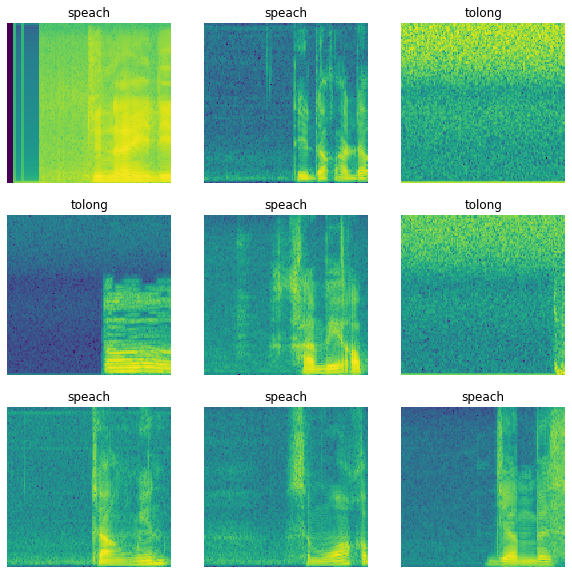

In [20]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func = get_waveform_and_label,
      num_parallel_calls= AUTOTUNE
  )
  output_ds = output_ds.map(
      map_func = get_spectrogram_and_label_id,
      num_parallel_calls = AUTOTUNE
  )
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [101]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape : ', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.


model = models.Sequential([
                           layers.Input(shape = input_shape),
                           # Downsample the input.
                           layers.Resizing(64, 64),
                           # Normalize.
                           norm_layer,
                           layers.Conv2D(32, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(128, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Flatten(),
                           layers.Dense(64, activation='relu'),
                           layers.Dropout(0.3),
                           layers.Dense(num_labels),
])

model.summary()

Input shape :  (124, 129, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_11 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 normalization_11 (Normaliza  (None, 64, 64, 1)        3         
 tion)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoo

In [102]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [103]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
13/13 [==============================] - 11s 802ms/step - loss: 0.6244 - accuracy: 0.8065 - val_loss: 0.4395 - val_accuracy: 0.9474
Epoch 2/10
13/13 [==============================] - 5s 369ms/step - loss: 0.4142 - accuracy: 0.8851 - val_loss: 0.2440 - val_accuracy: 0.8895
Epoch 3/10
13/13 [==============================] - 5s 367ms/step - loss: 0.2930 - accuracy: 0.9139 - val_loss: 0.1619 - val_accuracy: 0.9632
Epoch 4/10
13/13 [==============================] - 5s 370ms/step - loss: 0.2087 - accuracy: 0.9388 - val_loss: 0.1265 - val_accuracy: 0.9895
Epoch 5/10
13/13 [==============================] - 5s 366ms/step - loss: 0.1659 - accuracy: 0.9576 - val_loss: 0.1599 - val_accuracy: 0.9526
Epoch 6/10
13/13 [==============================] - 5s 369ms/step - loss: 0.1289 - accuracy: 0.9663 - val_loss: 0.0780 - val_accuracy: 0.9737
Epoch 7/10
13/13 [==============================] - 5s 367ms/step - loss: 0.0976 - accuracy: 0.9688 - val_loss: 0.0683 - val_accuracy: 0.9789
Epoch

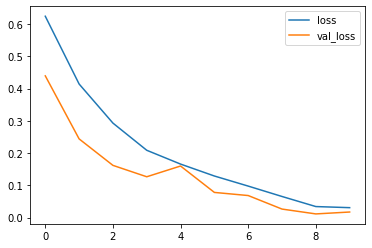

In [104]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [105]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [106]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 98%


IMPORT TFLITE


In [136]:
import pathlib
export = '/tflite/saved_model'
tf.saved_model.save(model, export)

#convert
converter = tf.lite.TFLiteConverter.from_saved_model(export)
tflite_model = converter.convert()

#save
tflite_model_file = pathlib.Path('/tflite/foo.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tflite/saved_model/assets


6873244